# Analysis of intervention measures

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from os.path import join
from os import listdir
import numpy as np
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Delta

### All students

In [4]:
src = '../data/simulation_results/delta/ensembles_intervention_screening_delta_all'

results = pd.DataFrame()
for f in listdir(src):
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])
    
results = results.reset_index(drop=True)
# subtract the index case
results['infected_agents'] = results['infected_agents'] - 1

# remove 100% occupancy and replace it with the "overbooked" setting,
# allowing as many students into lecture halls as enrolled
results = results[results['presence_fraction'] != 1.0]
results['presence_fraction'] = results['presence_fraction'].replace({'overbooked':1.0})

results['occupancy'] = results['presence_fraction']\
    .apply(lambda x: '{}%'.format(int(x * 100)) if x != 'overbooked' else 'overbooked')

In [5]:
results['scenario'] = np.nan
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])
results.loc[(0, 0, slice(None)), 'scenario'] = 'no masks'
results.loc[(1, 1, slice(None)), 'scenario'] = 'universal masks'
results.loc[(1, 0, slice(None)), 'scenario'] = 'masks students'
results.loc[(0, 1, slice(None)), 'scenario'] = 'masks faculty'
results = results.reset_index()

In [6]:
for scenario in ['no masks', 'masks faculty', 'masks students', 'universal masks']:
    for presence_fraction in [0.25, 0.5, 1.0]:
        subset = results[(results['scenario'] == scenario) & \
                         (results['presence_fraction'] == presence_fraction)]
        print('{} presence fraction {:1.0f}%: {:1.1f}% of index cases do not lead to an outbreak'\
              .format(scenario, presence_fraction * 100, 
                      len(subset[subset['infected_agents'] == 0]) / len(subset) * 100))

no masks presence fraction 25%: 71.2% of index cases do not lead to an outbreak
no masks presence fraction 50%: 61.7% of index cases do not lead to an outbreak
no masks presence fraction 100%: 52.5% of index cases do not lead to an outbreak
masks faculty presence fraction 25%: 73.0% of index cases do not lead to an outbreak
masks faculty presence fraction 50%: 63.3% of index cases do not lead to an outbreak
masks faculty presence fraction 100%: 54.3% of index cases do not lead to an outbreak
masks students presence fraction 25%: 85.2% of index cases do not lead to an outbreak
masks students presence fraction 50%: 78.6% of index cases do not lead to an outbreak
masks students presence fraction 100%: 71.1% of index cases do not lead to an outbreak
universal masks presence fraction 25%: 86.8% of index cases do not lead to an outbreak
universal masks presence fraction 50%: 80.1% of index cases do not lead to an outbreak
universal masks presence fraction 100%: 73.0% of index cases do not le

In [7]:
results['scenario'] = np.nan
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])
results.loc[(0, 0, 0.5), 'scenario'] = '50% occupancy, no masks'
results.loc[(1, 1, 0.5), 'scenario'] = '50% occupancy, masks'
results.loc[(1, 0, 0.5), 'scenario'] = '50% occupancy, masks students'
results.loc[(0, 1, 0.5), 'scenario'] = '50% occupancy, masks faculty'

results.loc[(0, 0, 1), 'scenario'] = '100% occupancy, no masks'
results.loc[(1, 1, 1), 'scenario'] = '100% occupancy, masks'
results.loc[(1, 0, 1), 'scenario'] = '100% occupancy, masks students'
results.loc[(0, 1, 1), 'scenario'] = '100% occupancy, masks faculty'
results = results.reset_index()

In [8]:
outbreaks = results[results['infected_agents'] > 0].copy()

### 80% vaccination coverage

#### Fig 1: Kernel density plot

<ipython-input-9-9298d14a7a1c>:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[0][0].set_xlim(0, 1e4)


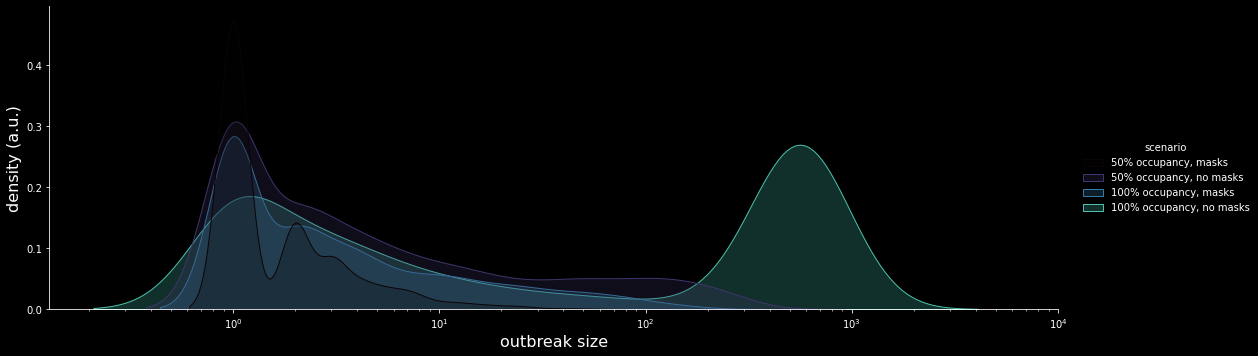

In [9]:
#fig, ax = plt.subplots()
cmap = sns.color_palette("mako", as_cmap=True)
scenarios = ['100% occupancy, no masks', '100% occupancy, masks',
             '50% occupancy, no masks', '50% occupancy, masks']
scenarios.reverse()
colors = [cmap(0.75), cmap(0.5), cmap(0.25), cmap(0)]
colors.reverse()

vacc_ratio = 0.8
subset = outbreaks[(outbreaks['scenario'].isin(scenarios)) & \
                   (outbreaks['presence_fraction'].isin([1, 0.5])) & \
                   (outbreaks['unistudent_vaccination_ratio'] == vacc_ratio)]

g = sns.displot(subset, x="infected_agents", hue="scenario", kind="kde", 
                fill=True, log_scale=True, height=5, aspect=3,
                hue_order=scenarios, palette=colors)

g.axes[0][0].set_xlim(0, 1e4) 
g.set_axis_labels("outbreak size", "density (a.u.)", fontsize=16)
plt.savefig('../plots/outbreak_sizes.svg')

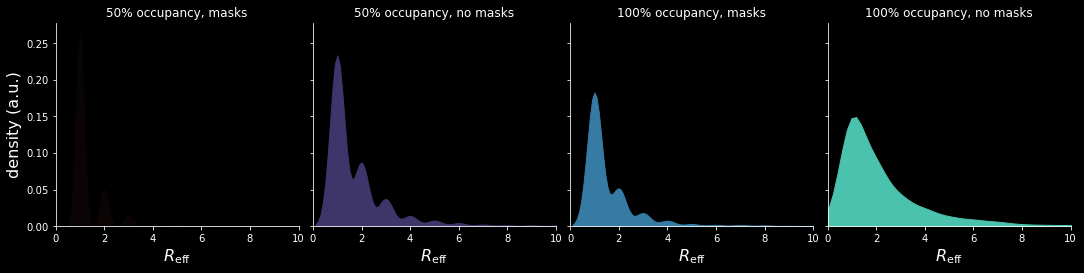

In [10]:
#fig, ax = plt.subplots()
cmap = sns.color_palette("mako", as_cmap=True)
scenarios = ['100% occupancy, no masks', '100% occupancy, masks',
             '50% occupancy, no masks', '50% occupancy, masks']
scenarios.reverse()
colors = [cmap(0.75), cmap(0.5), cmap(0.25), cmap(0)]
colors.reverse()

vacc_ratio = 0.8
subset = outbreaks[(outbreaks['scenario'].isin(scenarios)) & \
                   (outbreaks['presence_fraction'].isin([1, 0.5])) & \
                   (outbreaks['unistudent_vaccination_ratio'] == vacc_ratio)]

g = sns.displot(subset, x="R0", col="scenario", kind="kde", 
                fill=True, height=15/4, aspect=1,
                col_order=scenarios)

for i in range(len(scenarios)):
    g.axes[0][i].set_xlim(0, 10)
    g.axes[0][i].properties()['children'][0].set_color(colors[i])
    
    g.axes[0][i].set_title(scenarios[i])
g.set_axis_labels("$R_\\mathrm{eff}$", "density (a.u.)", fontsize=16)
plt.savefig('../plots/R0.svg')

In [11]:
def print_stats(df, sm, lm, pf, vr, stat):
    '''
    Parameters:
    -----------
    df: pandas DataFrame
        Simulation data of outbreaks
    sm: integer (0, 1)
        Student masks
    lm: integer (0, 1)
        Lecturer masks
    pf: float (0.25, 0.5, 1.0)
        Fraction of students present in lecture halls
    stat: string ('infected_agents' or 'RO')
        Observable for which statistics should be calculated
    '''
    print('************* {} *************'.format(stat))
    print('student masks: {}, lecturer masks: {}, presence fraction: {}, vaccination ratio: {}'\
             .format(sm, lm, pf, vr))
    print('mean {}: '.format(df.loc[sm, lm, pf, vr][stat].mean()))
    print('95% credible interval: [{}; {}] '\
              .format(df.loc[sm, lm, pf, vr][stat].quantile(0.025),
                      df.loc[sm, lm, pf, vr][stat].quantile(0.975)))
    print('maximum {}: '.format(df.loc[sm, lm, pf, vr][stat].max()))
    print('**************************')
    print()

#### Stats 80% vaccination

In [12]:
vacc_ratio = 0.8
subset = results[results['unistudent_vaccination_ratio'] == vacc_ratio]
subset = subset.set_index(['unistudent_mask', 'lecturer_mask', 
                             'presence_fraction', 'unistudent_vaccination_ratio'])

In [13]:
# 100 % occupancy
print('100% occupancy')
print_stats(subset, 0, 0, 1, 0.8, 'R0')
print_stats(subset, 0, 0, 1, 0.8, 'infected_agents')

# 100 % occupancy & masks
print('100% occupancy & masks')
print_stats(subset, 1, 1, 1, 0.8, 'R0')
print_stats(subset, 1, 1, 1, 0.8, 'infected_agents')

# 50 % occupancy
print('50% occupancy')
print_stats(subset, 0, 0, 0.5, 0.8, 'R0')
print_stats(subset, 0, 0, 0.5, 0.8, 'infected_agents')

# 50 % occupancy & masks
print('50% occupancy % masks')
print_stats(subset, 1, 1, 0.5, 0.8, 'R0')
print_stats(subset, 1, 1, 0.5, 0.8, 'infected_agents')

100% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.8
mean 1.0508: 
95% credible interval: [0.0; 6.0] 
maximum 36.0: 
**************************

************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.8
mean 110.0428: 
95% credible interval: [0.0; 674.0249999999996] 
maximum 858.0: 
**************************

100% occupancy & masks
************* R0 *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.8
mean 0.3841: 
95% credible interval: [0.0; 3.0] 
maximum 17.0: 
**************************

************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.8
mean 2.1488: 
95% credible interval: [0.0; 22.0] 
maximum 211.0: 
**************************

50% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0, presence fracti

#### Stats 70% vaccination

In [14]:
vacc_ratio = 0.7
subset = results[results['unistudent_vaccination_ratio'] == vacc_ratio]
subset = subset.set_index(['unistudent_mask', 'lecturer_mask', 
                             'presence_fraction', 'unistudent_vaccination_ratio'])

In [15]:
# 100 % occupancy
print('100% occupancy')
print_stats(subset, 0, 0, 1, 0.7, 'R0')
print_stats(subset, 0, 0, 1, 0.7, 'infected_agents')

# 100 % occupancy & masks
print('100% occupancy & masks')
print_stats(subset, 1, 1, 1, 0.7, 'R0')
print_stats(subset, 1, 1, 1, 0.7, 'infected_agents')

# 50 % occupancy
print('50% occupancy')
print_stats(subset, 0, 0, 0.5, 0.7, 'R0')
print_stats(subset, 0, 0, 0.5, 0.7, 'infected_agents')

# 50 % occupancy & masks
print('50% occupancy % masks')
print_stats(subset, 1, 1, 0.5, 0.7, 'R0')
print_stats(subset, 1, 1, 0.5, 0.7, 'infected_agents')

100% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.7
mean 1.5289: 
95% credible interval: [0.0; 9.0] 
maximum 64.0: 
**************************

************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.7
mean 450.9745: 
95% credible interval: [0.0; 1536.0249999999996] 
maximum 1742.0: 
**************************

100% occupancy & masks
************* R0 *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.7
mean 0.5451: 
95% credible interval: [0.0; 4.0] 
maximum 20.0: 
**************************

************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.7
mean 16.3702: 
95% credible interval: [0.0; 267.02499999999964] 
maximum 543.0: 
**************************

50% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0

## Omicron

### All students

In [75]:
src = '../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all'

results = pd.DataFrame()
for f in listdir(src):
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])
    
results = results.reset_index(drop=True)
# subtract the index case
results['infected_agents'] = results['infected_agents'] - 1

# rename "overbooked" to 100% presence fraction, since a float is more handy
results['presence_fraction'] = results['presence_fraction'].replace({'overbooked':1.0})

results['occupancy'] = results['presence_fraction']\
    .apply(lambda x: '{}%'.format(int(x * 100)) if x != 'overbooked' else 'overbooked')

In [76]:
results['scenario'] = np.nan
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])
results.loc[(0, 0, slice(None)), 'scenario'] = 'no masks'
results.loc[(1, 1, slice(None)), 'scenario'] = 'masks'
results = results.reset_index()

In [77]:
for scenario in ['no masks', 'masks']:
    for presence_fraction in [0.25, 0.5, 1.0]:
        subset = results[(results['scenario'] == scenario) & \
                         (results['presence_fraction'] == presence_fraction)]
        print('{} + presence fraction {:1.0f}%: {:1.1f}% of index cases do not lead to an outbreak'\
              .format(scenario, presence_fraction * 100, 
                      len(subset[subset['infected_agents'] == 0]) / len(subset) * 100))

no masks + presence fraction 25%: 45.8% of index cases do not lead to an outbreak
no masks + presence fraction 50%: 35.8% of index cases do not lead to an outbreak
no masks + presence fraction 100%: 29.4% of index cases do not lead to an outbreak
masks + presence fraction 25%: 67.8% of index cases do not lead to an outbreak
masks + presence fraction 50%: 57.7% of index cases do not lead to an outbreak
masks + presence fraction 100%: 47.9% of index cases do not lead to an outbreak


In [78]:
results['scenario'] = np.nan
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])
results.loc[(0, 0, 0.25), 'scenario'] = '25% occupancy, no masks'
results.loc[(1, 1, 0.25), 'scenario'] = '25% occupancy, masks'


results.loc[(0, 0, 0.5), 'scenario'] = '50% occupancy, no masks'
results.loc[(1, 1, 0.5), 'scenario'] = '50% occupancy, masks'

results.loc[(0, 0, 1), 'scenario'] = '100% occupancy, no masks'
results.loc[(1, 1, 1), 'scenario'] = '100% occupancy, masks'
results = results.reset_index()

In [79]:
results['transmission_risk_vaccination_modifier'] = results['transmission_risk_vaccination_modifier'].apply(eval)
results['transmission_risk_vaccination_modfier_reception'] = [i['reception'] for i in  results['transmission_risk_vaccination_modifier']]

In [80]:
outbreaks = results[results['infected_agents'] > 0].copy()

### 80% vaccination coverage

#### Fig 1: Kernel density plot measures

<ipython-input-81-4160e7bd2dbb>:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[0][0].set_xlim(0, 1e5)


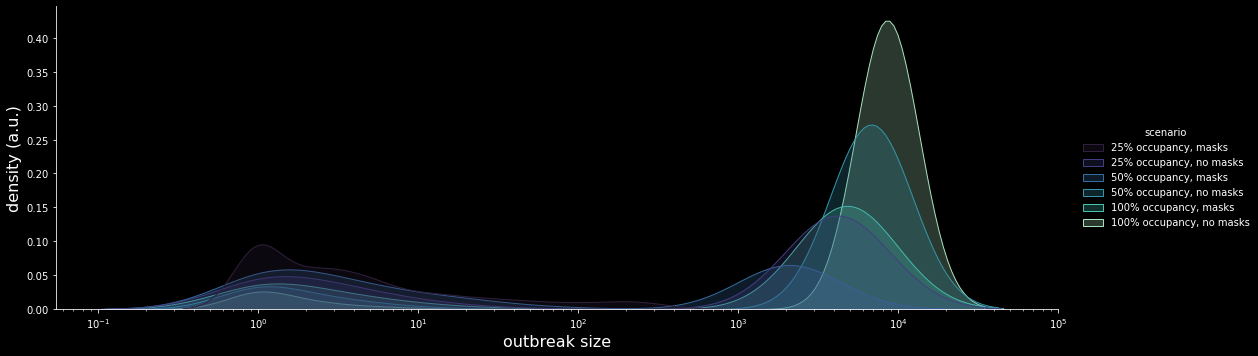

In [81]:
# select vaccination ratio and transmission risk modification by vaccination
# for the plot
transmission_risk_vaccination_modfier_reception = 0.4

cmap = sns.color_palette("mako", as_cmap=True)
scenarios = ['100% occupancy, no masks', '100% occupancy, masks',
             '50% occupancy, no masks', '50% occupancy, masks',
             '25% occupancy, no masks', '25% occupancy, masks']
scenarios.reverse()
colors = [cmap(0.9), cmap(0.75), cmap(0.6), cmap(0.45), cmap(0.3), cmap(0.15)]
colors.reverse()

subset = outbreaks[(outbreaks['scenario'].isin(scenarios)) & \
                   (outbreaks['presence_fraction'].isin([1, 0.5, 0.25])) & \
                   (outbreaks['transmission_risk_vaccination_modfier_reception'] == \
                       transmission_risk_vaccination_modfier_reception)] 

g = sns.displot(subset, x="infected_agents", hue="scenario", kind="kde", 
                fill=True, log_scale=True, height=5, aspect=3,
                hue_order=scenarios, palette=colors)

g.axes[0][0].set_xlim(0, 1e5) 
g.set_axis_labels("outbreak size", "density (a.u.)", fontsize=16)
plt.savefig('../plots/outbreak_sizes.svg')

#### Kernel density plot vaccination efficacy

In [87]:
subset["transmission_risk_vaccination_modfier_reception"].unique()

array([0.6, 0.2, 0. , 0.4])

<ipython-input-91-abed64cb6a67>:22: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[0][0].set_xlim(0, 1e4)


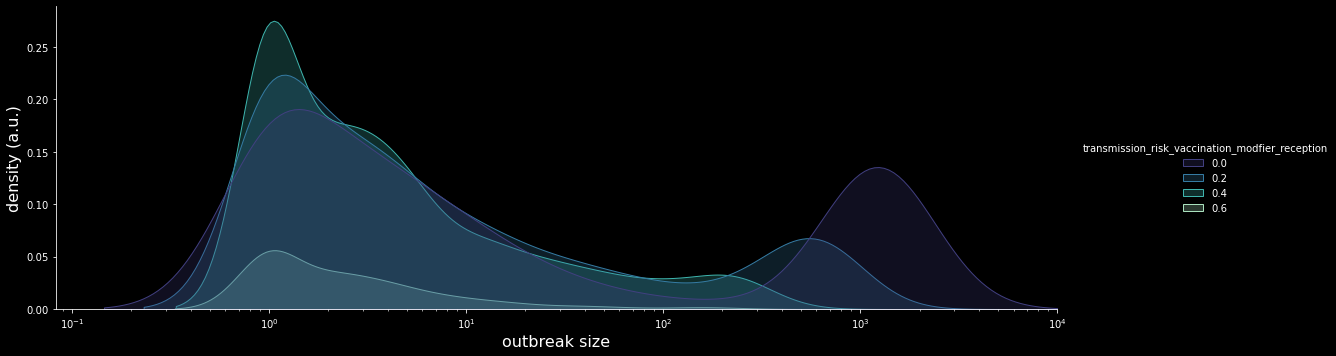

In [91]:
# select vaccination ratio and transmission risk modification by vaccination
# for the plot
transmission_risk_vaccination_modfier_reception = 0.4
scenario = "25% occupancy, masks"

cmap = sns.color_palette("mako", as_cmap=True)
vaccination_modfier_reception = [0.0, 0.2, 0.4, 0.6]
scenarios.reverse()
colors = [cmap(0.9), cmap(0.7), cmap(0.5), cmap(0.3)]
colors.reverse()

subset = outbreaks[(outbreaks['scenario'] == scenario) & \
                   (outbreaks['presence_fraction'] == 0.25) & \
                   (outbreaks['transmission_risk_vaccination_modfier_reception'] \
                       .isin(vaccination_modfier_reception))] 

g = sns.displot(subset, x="infected_agents", 
                hue="transmission_risk_vaccination_modfier_reception", kind="kde", 
                fill=True, log_scale=True, height=5, aspect=3,
                hue_order=vaccination_modfier_reception, palette=colors)

g.axes[0][0].set_xlim(0, 1e4) 
g.set_axis_labels("outbreak size", "density (a.u.)", fontsize=16)
#plt.savefig('../plots/outbreak_sizes.svg')

#### Scatterplot vaccination efficacy over $R$

In [130]:
def plot_mean_outcomes(ax, color, scenario, outcome, df, se=False):
    col = "transmission_risk_vaccination_modfier_reception"
    subset = df[df["scenario"] == scenario]

    mean_outcomes = subset[[col, "infected_agents", "R0"]]\
        .groupby(col)\
        .agg(["mean", "std", "count"])\
        .reset_index()

    ax.plot(mean_outcomes[col], mean_outcomes[outcome]["mean"],
            'o-', color=color, label=scenario)
    if se:
        ax.fill_between(mean_outcomes[col],
                        mean_outcomes[outcome]["mean"],
                        mean_outcomes[outcome]["mean"] + \
                            mean_outcomes[outcome]["std"] / \
                            np.sqrt(mean_outcomes[outcome]["count"]),
                        alpha=0.2, color=color)
        ax.fill_between(mean_outcomes[col],
                        mean_outcomes[outcome]["mean"],
                        mean_outcomes[outcome]["mean"] - \
                            mean_outcomes[outcome]["std"] / \
                            np.sqrt(mean_outcomes[outcome]["count"]),
                        alpha=0.2, color=color)

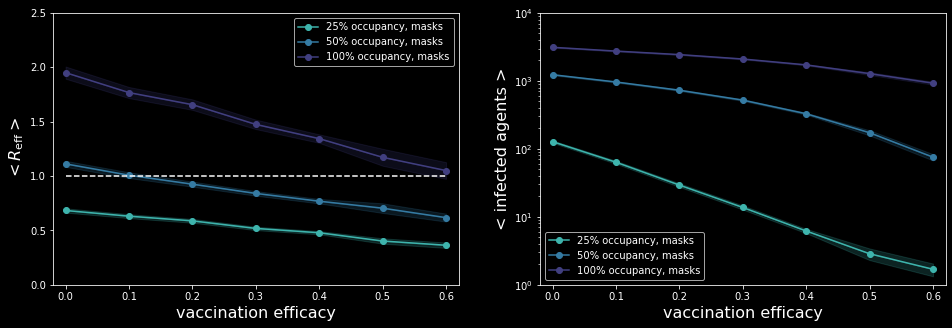

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_mean_outcomes(axes[0], cmap(0.7), "25% occupancy, masks", "R0", results, se=True)
plot_mean_outcomes(axes[0], cmap(0.5), "50% occupancy, masks", "R0", results, se=True)
plot_mean_outcomes(axes[0], cmap(0.3), "100% occupancy, masks", "R0", results, se=True)
axes[0].set_ylabel("$< R_\mathrm{eff} >$", fontsize=16)
axes[0].set_xlabel("vaccination efficacy", fontsize=16)
axes[0].set_ylim(0.0, 2.5)
axes[0].set_xlim(-0.02, 0.62)
axes[0].plot([0, 0.6], [1, 1], '--', color='w')
axes[0].legend()

plot_mean_outcomes(axes[1], cmap(0.7), "25% occupancy, masks", "infected_agents", results, se=True)
plot_mean_outcomes(axes[1], cmap(0.5), "50% occupancy, masks", "infected_agents", results, se=True)
plot_mean_outcomes(axes[1], cmap(0.3), "100% occupancy, masks", "infected_agents", results, se=True)
axes[1].set_ylabel("< infected agents >", fontsize=16)
axes[1].set_xlabel("vaccination efficacy", fontsize=16)
axes[1].set_xlim(-0.02, 0.62)
axes[1].set_ylim(1e0, 1e4)
axes[1].set_yscale("log")
axes[1].legend()

#### Kernel density $R_\mathrm{eff}$ individual scenarios

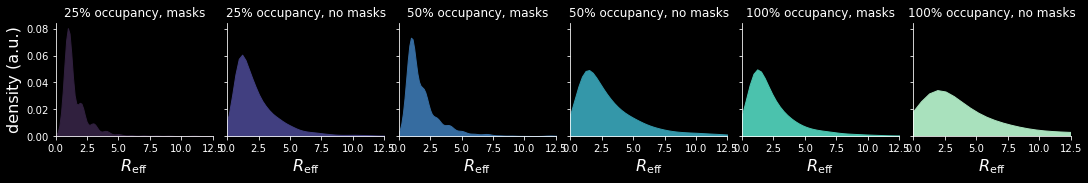

In [82]:
# select vaccination ratio and transmission risk modification by vaccination
# for the plot
vacc_ratio = 0.8
transmission_risk_vaccination_modfier_reception = 0.4

cmap = sns.color_palette("mako", as_cmap=True)
scenarios = ['100% occupancy, no masks', '100% occupancy, masks',
             '50% occupancy, no masks', '50% occupancy, masks',
             '25% occupancy, no masks', '25% occupancy, masks']
scenarios.reverse()
colors = [cmap(0.9), cmap(0.75), cmap(0.6), cmap(0.45), cmap(0.3), cmap(0.15)]
colors.reverse()

subset = outbreaks[(outbreaks['scenario'].isin(scenarios)) & \
                   (outbreaks['presence_fraction'].isin([1, 0.5, 0.25])) & \
                   (outbreaks['unistudent_vaccination_ratio'] == vacc_ratio) & \
                   (outbreaks['transmission_risk_vaccination_modfier_reception'] == \
                       transmission_risk_vaccination_modfier_reception)] 

g = sns.displot(subset, x="R0", col="scenario", kind="kde", 
                fill=True, height=15/6, aspect=1,
                col_order=scenarios)

for i in range(len(scenarios)):
    g.axes[0][i].set_xlim(0, 12.5)
    g.axes[0][i].properties()['children'][0].set_color(colors[i])
    
    g.axes[0][i].set_title(scenarios[i])
g.set_axis_labels("$R_\\mathrm{eff}$", "density (a.u.)", fontsize=16)
plt.savefig('../plots/R0.svg')

In [64]:
def print_stats(df, sm, lm, pf, vr, stat):
    '''
    Parameters:
    -----------
    df: pandas DataFrame
        Simulation data of outbreaks
    sm: integer (0, 1)
        Student masks
    lm: integer (0, 1)
        Lecturer masks
    pf: float (0.25, 0.5, 1.0)
        Fraction of students present in lecture halls
    stat: string ('infected_agents' or 'RO')
        Observable for which statistics should be calculated
    '''
    print('************* {} *************'.format(stat))
    print('student masks: {}, lecturer masks: {}, presence fraction: {}, vaccination ratio: {}'\
             .format(sm, lm, pf, vr))
    print('mean {}: '.format(df.loc[sm, lm, pf, vr][stat].mean()))
    print('95% credible interval: [{}; {}] '\
              .format(df.loc[sm, lm, pf, vr][stat].quantile(0.025),
                      df.loc[sm, lm, pf, vr][stat].quantile(0.975)))
    print('maximum {}: '.format(df.loc[sm, lm, pf, vr][stat].max()))
    print('**************************')
    print()

#### Stats 80% vaccination

In [68]:
vacc_ratio = 0.8
transmission_risk_vaccination_modfier_reception = 0.4

subset = results[(results['unistudent_vaccination_ratio'] == vacc_ratio) & \
                 (results['transmission_risk_vaccination_modfier_reception'] == \
                     transmission_risk_vaccination_modfier_reception)].copy()

subset = subset.set_index(['unistudent_mask', 'lecturer_mask', 
                             'presence_fraction', 'unistudent_vaccination_ratio'])

In [74]:
# 100 % occupancy
print('*************************')
print('***** 100% occupancy ****')
print('*************************')
print('no maks')
print_stats(subset, 0, 0, 1, 0.8, 'R0')
print_stats(subset, 0, 0, 1, 0.8, 'infected_agents')

# 100 % occupancy & masks
print('masks')
print_stats(subset, 1, 1, 1, 0.8, 'R0')
print_stats(subset, 1, 1, 1, 0.8, 'infected_agents')

# 50 % occupancy
print('*************************')
print('***** 50% occupancy *****')
print('*************************')
print('no masks')
print_stats(subset, 0, 0, 0.5, 0.8, 'R0')
print_stats(subset, 0, 0, 0.5, 0.8, 'infected_agents')

# 50 % occupancy & masks
print('masks')
print_stats(subset, 1, 1, 0.5, 0.8, 'R0')
print_stats(subset, 1, 1, 0.5, 0.8, 'infected_agents')

# 25 % occupancy
print('*************************')
print('***** 25% occupancy *****')
print('*************************')
print('no masks')
print_stats(subset, 0, 0, 0.25, 0.8, 'R0')
print_stats(subset, 0, 0, 0.25, 0.8, 'infected_agents')

# 25 % occupancy & masks
print('masks')
print_stats(subset, 1, 1, 0.25, 0.8, 'R0')
print_stats(subset, 1, 1, 0.25, 0.8, 'infected_agents')

*************************
***** 100% occupancy ****
*************************
no maks
************* R0 *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.8
mean 3.4252: 
95% credible interval: [0.0; 17.0] 
maximum 122.0: 
**************************

************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.8
mean 5394.4412: 
95% credible interval: [0.0; 8677.025] 
maximum 8788.0: 
**************************

masks
************* R0 *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.8
mean 1.3446: 
95% credible interval: [0.0; 8.0] 
maximum 56.0: 
**************************

************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.8
mean 1723.6588: 
95% credible interval: [0.0; 4962.0] 
maximum 5107.0: 
**************************

*************************
***** 50% occupa